# Vanilla GAN for Breast Cancer Wisconsin (Diagnostic) - Tabular

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import ks_2samp, wasserstein_distance
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

In [2]:
# device configuration

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 64
hidden = 256
batch_size = 256
epochs = 200
lr = 2e-4
betas = (0.5, 0.999)
label_smooth_real = 0.9
synthetic_n = 5000
dup_eps = 0.10

In [3]:
#   Load and preprocess the Breast Cancer Wisconsin dataset

data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.int64)
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train).astype(np.float32)
X_test_s  = scaler.transform(X_test).astype(np.float32)

train_tensor = torch.tensor(X_train_s)
loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True, drop_last=True)

input_dim = X.shape[1]

In [4]:
# Models (Vanilla MLP GAN)

class Generator(nn.Module):
    def __init__(self, z_dim, x_dim, h=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, h), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h, h), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h, x_dim)  # linear head (standardized space)
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, x_dim, h=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim, h), nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(h, h//2), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h//2, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator(latent_dim, input_dim, hidden).to(device)
D = Discriminator(input_dim, hidden).to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

In [5]:
# Train GAN + track epoch metrics

fixed_z = torch.randn(2048, latent_dim, device=device)
mean_abs_rel_errors = []
real_means = X_train.mean(axis=0)

for epoch in range(1, epochs + 1):
    G.train(); D.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for real in pbar:
        real = real.to(device)
        b = real.size(0)

        # -- Train D --
        z = torch.randn(b, latent_dim, device=device)
        with torch.no_grad():
            fake = G(z)
        D_real = D(real)
        D_fake = D(fake)

        real_labels = torch.full_like(D_real, label_smooth_real)
        fake_labels = torch.zeros_like(D_fake)
        loss_D = 0.5 * (criterion(D_real, real_labels) + criterion(D_fake, fake_labels))
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # -- Train G --
        z = torch.randn(b, latent_dim, device=device)
        fake = G(z)
        D_fake = D(fake)
        loss_G = criterion(D_fake, torch.ones_like(D_fake))
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

        pbar.set_postfix(loss_D=float(loss_D.detach().cpu()),
                         loss_G=float(loss_G.detach().cpu()))

    # epoch metric: mean absolute relative error of feature means (original scale)
    with torch.no_grad():
        synth_s = G(fixed_z).cpu().numpy()
        synth = scaler.inverse_transform(synth_s)
        synth_means = synth.mean(axis=0)
        mar_err = float(np.mean(np.abs(synth_means - real_means) / (np.abs(real_means) + 1e-6)))
        mean_abs_rel_errors.append(mar_err)
    print(f"Epoch {epoch}: mean abs rel err (means) = {mar_err:.3f}")

Epoch 1: mean abs rel err (means) = 0.032


Epoch 2: mean abs rel err (means) = 0.033


Epoch 3: mean abs rel err (means) = 0.035


Epoch 4: mean abs rel err (means) = 0.038


Epoch 5: mean abs rel err (means) = 0.041


Epoch 6: mean abs rel err (means) = 0.045


Epoch 7: mean abs rel err (means) = 0.049


Epoch 8: mean abs rel err (means) = 0.053


Epoch 9: mean abs rel err (means) = 0.056


Epoch 10: mean abs rel err (means) = 0.061


Epoch 11: mean abs rel err (means) = 0.065


Epoch 12: mean abs rel err (means) = 0.070


Epoch 13: mean abs rel err (means) = 0.075


Epoch 14: mean abs rel err (means) = 0.080


Epoch 15: mean abs rel err (means) = 0.084


Epoch 16: mean abs rel err (means) = 0.087


Epoch 17: mean abs rel err (means) = 0.089


Epoch 18: mean abs rel err (means) = 0.090


Epoch 19: mean abs rel err (means) = 0.090


Epoch 20: mean abs rel err (means) = 0.090


Epoch 21: mean abs rel err (means) = 0.089


Epoch 22: mean abs rel err (means) = 0.088


Epoch 23: mean abs rel err (means) = 0.088


Epoch 24: mean abs rel err (means) = 0.089


Epoch 25: mean abs rel err (means) = 0.090


Epoch 26: mean abs rel err (means) = 0.094


Epoch 27: mean abs rel err (means) = 0.099


Epoch 28: mean abs rel err (means) = 0.107


Epoch 29: mean abs rel err (means) = 0.117


Epoch 30: mean abs rel err (means) = 0.126


Epoch 31: mean abs rel err (means) = 0.135


Epoch 32: mean abs rel err (means) = 0.142


Epoch 33: mean abs rel err (means) = 0.149


Epoch 34: mean abs rel err (means) = 0.154


Epoch 35: mean abs rel err (means) = 0.157


Epoch 36: mean abs rel err (means) = 0.159


Epoch 37: mean abs rel err (means) = 0.159


Epoch 38: mean abs rel err (means) = 0.158


Epoch 39: mean abs rel err (means) = 0.160


Epoch 40: mean abs rel err (means) = 0.160


Epoch 41: mean abs rel err (means) = 0.159


Epoch 42: mean abs rel err (means) = 0.159


Epoch 43: mean abs rel err (means) = 0.161


Epoch 44: mean abs rel err (means) = 0.162


Epoch 45: mean abs rel err (means) = 0.164


Epoch 46: mean abs rel err (means) = 0.165


Epoch 47: mean abs rel err (means) = 0.167


Epoch 48: mean abs rel err (means) = 0.168


Epoch 49: mean abs rel err (means) = 0.170


Epoch 50: mean abs rel err (means) = 0.172


Epoch 51: mean abs rel err (means) = 0.172


Epoch 52: mean abs rel err (means) = 0.175


Epoch 53: mean abs rel err (means) = 0.178


Epoch 54: mean abs rel err (means) = 0.182


Epoch 55: mean abs rel err (means) = 0.190


Epoch 56: mean abs rel err (means) = 0.198


Epoch 57: mean abs rel err (means) = 0.204


Epoch 58: mean abs rel err (means) = 0.212


Epoch 59: mean abs rel err (means) = 0.218


Epoch 60: mean abs rel err (means) = 0.224


Epoch 61: mean abs rel err (means) = 0.228


Epoch 62: mean abs rel err (means) = 0.231


Epoch 63: mean abs rel err (means) = 0.232


Epoch 64: mean abs rel err (means) = 0.234


Epoch 65: mean abs rel err (means) = 0.237


Epoch 66: mean abs rel err (means) = 0.240


Epoch 67: mean abs rel err (means) = 0.242


Epoch 68: mean abs rel err (means) = 0.244


Epoch 69: mean abs rel err (means) = 0.248


Epoch 70: mean abs rel err (means) = 0.253


Epoch 71: mean abs rel err (means) = 0.256


Epoch 72: mean abs rel err (means) = 0.257


Epoch 73: mean abs rel err (means) = 0.257


Epoch 74: mean abs rel err (means) = 0.255


Epoch 75: mean abs rel err (means) = 0.254


Epoch 76: mean abs rel err (means) = 0.253


Epoch 77: mean abs rel err (means) = 0.254


Epoch 78: mean abs rel err (means) = 0.255


Epoch 79: mean abs rel err (means) = 0.256


Epoch 80: mean abs rel err (means) = 0.256


Epoch 81: mean abs rel err (means) = 0.258


Epoch 82: mean abs rel err (means) = 0.258


Epoch 83: mean abs rel err (means) = 0.258


Epoch 84: mean abs rel err (means) = 0.262


Epoch 85: mean abs rel err (means) = 0.266


Epoch 86: mean abs rel err (means) = 0.272


Epoch 87: mean abs rel err (means) = 0.275


Epoch 88: mean abs rel err (means) = 0.277


Epoch 89: mean abs rel err (means) = 0.277


Epoch 90: mean abs rel err (means) = 0.276


Epoch 91: mean abs rel err (means) = 0.274


Epoch 92: mean abs rel err (means) = 0.269


Epoch 93: mean abs rel err (means) = 0.266


Epoch 94: mean abs rel err (means) = 0.267


Epoch 95: mean abs rel err (means) = 0.270


Epoch 96: mean abs rel err (means) = 0.272


Epoch 97: mean abs rel err (means) = 0.271


Epoch 98: mean abs rel err (means) = 0.270


Epoch 99: mean abs rel err (means) = 0.270


Epoch 100: mean abs rel err (means) = 0.274


Epoch 101: mean abs rel err (means) = 0.276


Epoch 102: mean abs rel err (means) = 0.278


Epoch 103: mean abs rel err (means) = 0.280


Epoch 104: mean abs rel err (means) = 0.281


Epoch 105: mean abs rel err (means) = 0.280


Epoch 106: mean abs rel err (means) = 0.279


Epoch 107: mean abs rel err (means) = 0.280


Epoch 108: mean abs rel err (means) = 0.279


Epoch 109: mean abs rel err (means) = 0.279


Epoch 110: mean abs rel err (means) = 0.279


Epoch 111: mean abs rel err (means) = 0.279


Epoch 112: mean abs rel err (means) = 0.278


Epoch 113: mean abs rel err (means) = 0.276


Epoch 114: mean abs rel err (means) = 0.272


Epoch 115: mean abs rel err (means) = 0.268


Epoch 116: mean abs rel err (means) = 0.273


Epoch 117: mean abs rel err (means) = 0.280


Epoch 118: mean abs rel err (means) = 0.286


Epoch 119: mean abs rel err (means) = 0.291


Epoch 120: mean abs rel err (means) = 0.294


Epoch 121: mean abs rel err (means) = 0.298


Epoch 122: mean abs rel err (means) = 0.300


Epoch 123: mean abs rel err (means) = 0.300


Epoch 124: mean abs rel err (means) = 0.302


Epoch 125: mean abs rel err (means) = 0.304


Epoch 126: mean abs rel err (means) = 0.306


Epoch 127: mean abs rel err (means) = 0.307


Epoch 128: mean abs rel err (means) = 0.308


Epoch 129: mean abs rel err (means) = 0.315


Epoch 130: mean abs rel err (means) = 0.324


Epoch 131: mean abs rel err (means) = 0.332


Epoch 132: mean abs rel err (means) = 0.339


Epoch 133: mean abs rel err (means) = 0.345


Epoch 134: mean abs rel err (means) = 0.350


Epoch 135: mean abs rel err (means) = 0.357


Epoch 136: mean abs rel err (means) = 0.364


Epoch 137: mean abs rel err (means) = 0.368


Epoch 138: mean abs rel err (means) = 0.371


Epoch 139: mean abs rel err (means) = 0.375


Epoch 140: mean abs rel err (means) = 0.376


Epoch 141: mean abs rel err (means) = 0.376


Epoch 142: mean abs rel err (means) = 0.375


Epoch 143: mean abs rel err (means) = 0.373


Epoch 144: mean abs rel err (means) = 0.369


Epoch 145: mean abs rel err (means) = 0.363


Epoch 146: mean abs rel err (means) = 0.359


Epoch 147: mean abs rel err (means) = 0.354


Epoch 148: mean abs rel err (means) = 0.349


Epoch 149: mean abs rel err (means) = 0.342


Epoch 150: mean abs rel err (means) = 0.347


Epoch 151: mean abs rel err (means) = 0.352


Epoch 152: mean abs rel err (means) = 0.355


Epoch 153: mean abs rel err (means) = 0.356


Epoch 154: mean abs rel err (means) = 0.356


Epoch 155: mean abs rel err (means) = 0.355


Epoch 156: mean abs rel err (means) = 0.353


Epoch 157: mean abs rel err (means) = 0.348


Epoch 158: mean abs rel err (means) = 0.341


Epoch 159: mean abs rel err (means) = 0.333


Epoch 160: mean abs rel err (means) = 0.323


Epoch 161: mean abs rel err (means) = 0.313


Epoch 162: mean abs rel err (means) = 0.303


Epoch 163: mean abs rel err (means) = 0.296


Epoch 164: mean abs rel err (means) = 0.290


Epoch 165: mean abs rel err (means) = 0.284


Epoch 166: mean abs rel err (means) = 0.279


Epoch 167: mean abs rel err (means) = 0.277


Epoch 168: mean abs rel err (means) = 0.278


Epoch 169: mean abs rel err (means) = 0.281


Epoch 170: mean abs rel err (means) = 0.285


Epoch 171: mean abs rel err (means) = 0.289


Epoch 172: mean abs rel err (means) = 0.295


Epoch 173: mean abs rel err (means) = 0.301


Epoch 174: mean abs rel err (means) = 0.306


Epoch 175: mean abs rel err (means) = 0.310


Epoch 176: mean abs rel err (means) = 0.313


Epoch 177: mean abs rel err (means) = 0.314


Epoch 178: mean abs rel err (means) = 0.314


Epoch 179: mean abs rel err (means) = 0.314


Epoch 180: mean abs rel err (means) = 0.316


Epoch 181: mean abs rel err (means) = 0.315


Epoch 182: mean abs rel err (means) = 0.314


Epoch 183: mean abs rel err (means) = 0.311


Epoch 184: mean abs rel err (means) = 0.306


Epoch 185: mean abs rel err (means) = 0.300


Epoch 186: mean abs rel err (means) = 0.293


Epoch 187: mean abs rel err (means) = 0.285


Epoch 188: mean abs rel err (means) = 0.275


Epoch 189: mean abs rel err (means) = 0.264


Epoch 190: mean abs rel err (means) = 0.253


Epoch 191: mean abs rel err (means) = 0.241


Epoch 192: mean abs rel err (means) = 0.229


Epoch 193: mean abs rel err (means) = 0.219


Epoch 194: mean abs rel err (means) = 0.213


Epoch 195: mean abs rel err (means) = 0.214


Epoch 196: mean abs rel err (means) = 0.217


Epoch 197: mean abs rel err (means) = 0.223


Epoch 198: mean abs rel err (means) = 0.229


Epoch 199: mean abs rel err (means) = 0.239


Epoch 200: mean abs rel err (means) = 0.249


In [6]:
# sampling

@torch.no_grad()
def sample_synthetic(n=synthetic_n):
    G.eval()
    xs = []
    left = n
    while left > 0:
        k = min(1024, left)
        z = torch.randn(k, latent_dim, device=device)
        xs.append(G(z).cpu().numpy())
        left -= k
    synth_s = np.vstack(xs).astype(np.float32)
    synth = scaler.inverse_transform(synth_s)
    return synth, synth_s

X_synth, X_synth_s = sample_synthetic(synthetic_n)

In [7]:
# --------------------
# Fidelity Metrics
# --------------------
def summary_stat_deltas(real, synth):
    def skew(x): m = x.mean(axis=0); s = x.std(axis=0) + 1e-12; z = (x - m) / s; return (z**3).mean(axis=0)
    def kurt(x): m = x.mean(axis=0); s = x.std(axis=0) + 1e-12; z = (x - m) / s; return (z**4).mean(axis=0)
    return {
        "mean_delta": float(np.abs(real.mean(axis=0) - synth.mean(axis=0)).mean()),
        "std_delta":  float(np.abs(real.std(axis=0)  - synth.std(axis=0)).mean()),
        "skew_delta": float(np.abs(skew(real) - skew(synth)).mean()),
        "kurt_delta": float(np.abs(kurt(real) - kurt(synth)).mean()),
    }

def correlation_frobenius(real, synth, normalize=True):
    cr = np.corrcoef(real, rowvar=False)
    cs = np.corrcoef(synth, rowvar=False)
    diff = np.nan_to_num(cr - cs)
    fro = np.linalg.norm(diff, ord='fro')
    return float(fro / real.shape[1] if normalize else fro)

def frechet_distance(real, synth):
    mu_r, mu_s = real.mean(axis=0), synth.mean(axis=0)
    cov_r, cov_s = np.cov(real, rowvar=False), np.cov(synth, rowvar=False)
    covmean = sqrtm(cov_r.dot(cov_s))
    if np.iscomplexobj(covmean):  # numeric guard
        covmean = covmean.real
    fd = np.sum((mu_r - mu_s)**2) + np.trace(cov_r + cov_s - 2*covmean)
    return float(fd)

def columnwise_distances(real, synth, feature_names):
    rows = []
    for j, name in enumerate(feature_names):
        r = real[:, j]; s = synth[:, j]
        ks, _ = ks_2samp(r, s)
        w  = wasserstein_distance(r, s)
        rows.append((name, float(ks), float(w), float(s.mean()), float(s.std())))
    rows.sort(key=lambda x: x[1], reverse=True)  # worst first
    return rows

In [8]:
# Use test split as the "unseen real" reference
fidelity = {
    "summary_deltas": summary_stat_deltas(X_test, X_synth),
    "corr_fro_norm":  correlation_frobenius(X_test, X_synth),
    "frechet":        frechet_distance(X_test, X_synth),
    "per_column":     columnwise_distances(X_test, X_synth, feature_names),
}

In [9]:
print("\n================= FIDELITY =================")
for k, v in fidelity["summary_deltas"].items():
    print(f"{k:>12s}: {v:.4f}")
print(f"corr_fro_norm : {fidelity['corr_fro_norm']:.4f}")
print(f"frechet       : {fidelity['frechet']:.4f}")
print("\nTop 10 columns by KS (worst):")
for name, ks, w, m, s in fidelity["per_column"][:10]:
    print(f"  {name:28s} KS={ks:6.3f} Wass={w:7.3f} synth_mean={m:9.3f} synth_std={s:9.3f}")


================= FIDELITY =================
  mean_delta: 20.5574
   std_delta: 30.2225
  skew_delta: 1.5180
  kurt_delta: 4.2543
corr_fro_norm : 0.5108
frechet       : 609225.8385

Top 10 columns by KS (worst):
  mean area                    KS= 0.802 Wass=457.395 synth_mean=  222.831 synth_std=  104.988
  worst concavity              KS= 0.711 Wass=  0.224 synth_mean=    0.464 synth_std=    0.056
  mean smoothness              KS= 0.708 Wass=  0.018 synth_mean=    0.080 synth_std=    0.004
  worst radius                 KS= 0.697 Wass=  5.655 synth_mean=   10.982 synth_std=    1.507
  mean symmetry                KS= 0.696 Wass=  0.031 synth_mean=    0.153 synth_std=    0.008
  symmetry error               KS= 0.675 Wass=  0.007 synth_mean=    0.013 synth_std=    0.002
  worst texture                KS= 0.649 Wass=  5.813 synth_mean=   20.028 synth_std=    1.854
  texture error                KS= 0.634 Wass=  0.413 synth_mean=    1.531 synth_std=    0.095
  mean perimeter          

In [10]:
# --------------------
# Utility (RandomForest)
# --------------------
def rf_eval(train_X, train_y, test_X, test_y, desc=""):
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    )
    rf.fit(train_X, train_y)
    prob = rf.predict_proba(test_X)[:, 1]
    pred = (prob >= 0.5).astype(int)
    return {
        "desc": desc,
        "ACC":  accuracy_score(test_y, pred),
        "AUC":  roc_auc_score(test_y, prob)
    }

In [11]:
# Prepare labels for synthetic by sampling from empirical distribution
rng = np.random.default_rng(42)
class_probs = np.bincount(y_train, minlength=2) / len(y_train)
y_synth = rng.choice(2, size=len(X_synth), p=class_probs)

# Evaluate three scenarios (all use standardized features for RF):
X_synth_std = scaler.transform(X_synth)
X_train_std = X_train_s
X_test_std  = X_test_s

util_tstr  = rf_eval(X_synth_std, y_synth, X_test_std, y_test, "TSTR: Train Synth -> Test Real")
util_trtr  = rf_eval(X_train_std, y_train, X_test_std, y_test, "TRTR: Train Real -> Test Real (baseline)")
util_combo = rf_eval(
    np.vstack([X_train_std, X_synth_std]),
    np.concatenate([y_train, y_synth]),
    X_test_std, y_test,
    "Train Real+Synth -> Test Real"
)

print("\n================= UTILITY (RandomForest) =================")
for u in [util_trtr, util_tstr, util_combo]:
    print(f"{u['desc']:35s} ACC={u['ACC']:.3f}  AUC={u['AUC']:.3f}")


================= UTILITY (RandomForest) =================
TRTR: Train Real -> Test Real (baseline) ACC=0.947  AUC=0.994
TSTR: Train Synth -> Test Real      ACC=0.632  AUC=0.348
Train Real+Synth -> Test Real       ACC=0.965  AUC=0.991


In [12]:
# Privacy Checks
# --------------------
# 1) Nearest-neighbor leakage summary (standardized space)
def nn_leakage_summary(real_train_s, synth_s):
    mins = []
    for i in range(min(len(synth_s), 5000)):
        d = np.sqrt(((real_train_s - synth_s[i])**2).sum(axis=1))
        mins.append(float(np.min(d)))
    mins = np.array(mins)
    return {
        "min": float(np.min(mins)),
        "p1": float(np.percentile(mins, 1)),
        "p5": float(np.percentile(mins, 5)),
        "median": float(np.median(mins))
    }

# 2) Duplication rate: % of synthetic points closer than dup_eps to *any* real train point
def duplication_rate(real_train_s, synth_s, eps=dup_eps):
    count = 0
    for i in range(len(synth_s)):
        d = np.sqrt(((real_train_s - synth_s[i])**2).sum(axis=1))
        if np.min(d) < eps:
            count += 1
    return float(count) / float(len(synth_s))

# 3) Membership Inference AUC (distance-based proxy):
#    For each real sample, compute distance to nearest synthetic.
#    Members = real_train, Non-members = real_test. If train pts tend to be closer to synth than test pts,
#    this AUC will be > 0.5 (privacy risk). 0.5 ~ no signal, 1.0 ~ perfect membership inference.
def mia_auc_distance(real_train_s, real_test_s, synth_s):
    def min_dists(A, B):
        out = []
        for i in range(len(A)):
            d = np.sqrt(((B - A[i])**2).sum(axis=1))
            out.append(float(np.min(d)))
        return np.array(out)
    d_train = min_dists(real_train_s, synth_s)
    d_test  = min_dists(real_test_s,  synth_s)
    scores  = -np.concatenate([d_train, d_test])  # closer -> larger score
    labels  = np.concatenate([np.ones_like(d_train), np.zeros_like(d_test)])  # 1=train(member), 0=test(non-member)
    return float(roc_auc_score(labels, scores))

privacy = {
    "nn_leakage_summary": nn_leakage_summary(X_train_s, X_synth_s),
    "duplication_rate@eps": duplication_rate(X_train_s, X_synth_s, eps=dup_eps),
    "membership_inference_auc": mia_auc_distance(X_train_s, X_test_s, X_synth_s),
    "dup_eps_used": dup_eps
}

print("\n================= PRIVACY =================")
print("Nearest-neighbor (std-space) min-dist summary (lower is closer/riskier):")
for k, v in privacy["nn_leakage_summary"].items():
    print(f"  {k:>6s}: {v:.4f}")
print(f"Duplication rate (L2<{privacy['dup_eps_used']:.2f}): {privacy['duplication_rate@eps']:.4%}")
print(f"Membership-Inference AUC (distance proxy): {privacy['membership_inference_auc']:.3f}  "
      f"(~0.5 is good; higher indicates risk)")


================= PRIVACY =================
Nearest-neighbor (std-space) min-dist summary (lower is closer/riskier):
     min: 1.8981
      p1: 2.2811
      p5: 2.4580
  median: 3.1139
Duplication rate (L2<0.10): 0.0000%
Membership-Inference AUC (distance proxy): 0.491  (~0.5 is good; higher indicates risk)


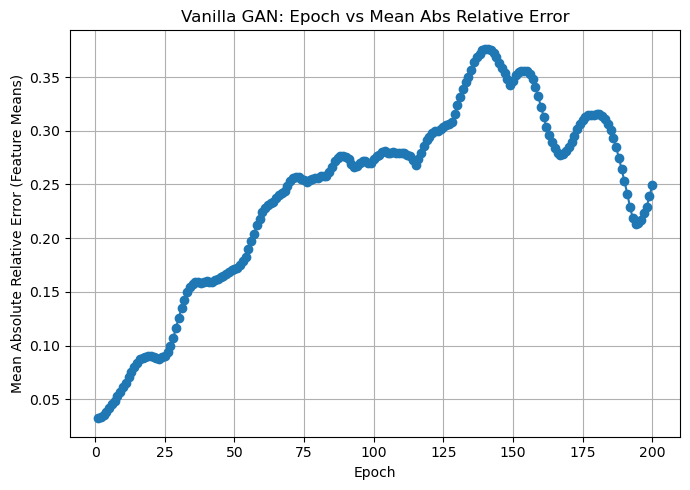

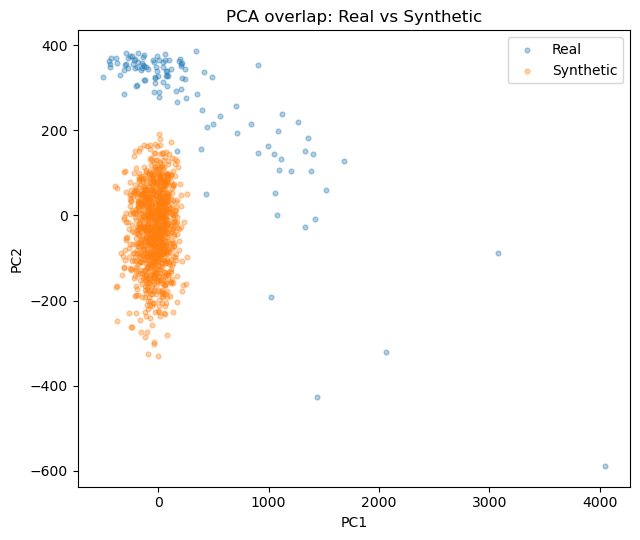

In [13]:
# --------------------
# Visuals
# --------------------
# 1) Epoch vs mean abs relative error
plt.figure(figsize=(7,5))
plt.plot(range(1, len(mean_abs_rel_errors)+1), mean_abs_rel_errors, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Relative Error (Feature Means)")
plt.title("Vanilla GAN: Epoch vs Mean Abs Relative Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) PCA overlap (qualitative)
def plot_pca_overlap(real, synth, n_real=1000, n_synth=1000):
    nr = min(n_real, len(real)); ns = min(n_synth, len(synth))
    both = np.vstack([real[:nr], synth[:ns]])
    pca = PCA(n_components=2, random_state=0)
    pcs = pca.fit_transform(both)
    rp = pcs[:nr]; sp = pcs[nr:]
    plt.figure(figsize=(6.5,5.5))
    plt.scatter(rp[:,0], rp[:,1], alpha=0.35, label="Real", s=12)
    plt.scatter(sp[:,0], sp[:,1], alpha=0.35, label="Synthetic", s=12)
    plt.legend()
    plt.title("PCA overlap: Real vs Synthetic")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout(); plt.show()

plot_pca_overlap(X_test, X_synth)

In [14]:
import pandas as pd
df = pd.DataFrame(X_synth, columns=feature_names)
df.to_csv("breast_cancer_synthetic_vanilla_gan.csv", index=False)
print("Saved to breast_cancer_synthetic_vanilla_gan.csv")

Saved to breast_cancer_synthetic_vanilla_gan.csv
